# Precipitation Nowcasting using Neural Networks (15%)

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)
- Create your own model **(Extra)**

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [1]:
!nvidia-smi

Mon Jun  3 20:20:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0             21W /   80W |     491MiB /   6144MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# For summarizing and visualizing models
# !pip install torchinfo
# !pip install torchviz
# %pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [3]:
# !pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [4]:
!wandb login 38816e3211c381377a18590e3ff774be8b145a6a

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\TUF\.netrc


In [5]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from torchviz import make_dot
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'2.0.1'

In [6]:
torch.cuda.is_available()

True

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [8]:
# !tar -xvf 'D:/Homework/2566_2/FRA501 Pattern Recognition/hw4/nowcastingHWdataset.tar.gz'

# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

wvapor.png --> https://drive.google.com/file/d/1grwLUBPEdULvLbOmjBXfx9hD9yFlNjyZ/view?usp=sharing

cloud1.png --> https://drive.google.com/file/d/12MVkAyyrqNKrCPzSkUcKmuqw_y-Svfyb/view?usp=sharing

cloud2.png --> https://drive.google.com/file/d/1h_n8AXbZS2DWoOu7Ktf9Jk5PKBwB1WMc/view?usp=sharing


We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [9]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [10]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


In [11]:
y_train[0:20]

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 6. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0.5],
       [0. , 2.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])

**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [12]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1 **(5 points)**

Explain each line of code in the function preprocess_for_ff()

**Ans:** 
For input data such as train, val and test they need to reshape data to 2 dims (entries, feature) from 5 dims (entries, time, height, width, channel) by entries * time and height * width * channel, we got 75 features in each entries. On the other hand, The label data of train, val and test have only one feature that is answer of each input data show in (entries, time, label) we need to reshape by multiply entries and time. This process make data suitable for feedforword model

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [13]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer # Normalize and add more augmentation here
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize and add more augmentation here
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [14]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [15]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [17]:
loss_fn = nn.MSELoss()

### TODO#2 **(5 points)**

Why is the loss MSE?

**Ans:**  MSE is popular in regression task because MSE is differentiable, facilitating efficient gradient-based optimization during training. It penalizes larger errors more, suitable for tasks where accurate predictions are crucial.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [19]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3 **(5 points)**

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** The activation function in the final dense layer is a linear function, as defined by self.out = nn.Linear(hidden_size, 1) This activation function is good because the output dimension of the linear activation matches the expected output shape, which is (hidden_size, 1)

In [20]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [21]:
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
print(sample_inputs.size(),sample_y.size())

torch.Size([1024, 1, 75]) torch.Size([1024, 1])


In [22]:
sample_inputs

tensor([[[ 0.5144,  0.2135,  0.1830,  ...,  0.5871,  0.1087,  0.1633]],

        [[ 0.6145,  0.7188,  0.7888,  ...,  0.4352,  0.9335,  0.8339]],

        [[ 0.3061, -0.0885, -0.0292,  ...,  0.2499,  0.0776,  0.1292]],

        ...,

        [[-0.3040, -0.8716, -0.8160,  ..., -0.1510, -0.5162, -0.5070]],

        [[ 0.6391,  0.4327,  0.4252,  ...,  0.7092,  0.4745,  0.5204]],

        [[ 0.0282, -0.5507, -0.4291,  ..., -0.0910, -0.4278, -0.3257]]],
       requires_grad=True)

In [23]:
sample_inputs[0]

tensor([[0.5144, 0.2135, 0.1830, 0.6873, 0.4445, 0.4375, 0.8290, 0.4239, 0.4701,
         0.8284, 0.4237, 0.4697, 0.8970, 0.1932, 0.3291, 0.5398, 0.3624, 0.3227,
         0.6874, 0.2285, 0.2859, 0.6865, 0.2278, 0.2853, 0.8283, 0.1321, 0.2616,
         0.8739, 0.1243, 0.2845, 0.4892, 0.4192, 0.3520, 0.6873, 0.1815, 0.2674,
         0.6865, 0.1809, 0.2668, 0.8049, 0.0620, 0.2061, 0.8042, 0.0620, 0.2059,
         0.4118, 0.3043, 0.2310, 0.4111, 0.3033, 0.2305, 0.6865, 0.2692, 0.2899,
         0.7339, 0.1988, 0.2695, 0.7333, 0.1989, 0.2693, 0.3855, 0.1672, 0.1101,
         0.3849, 0.1664, 0.1097, 0.5384, 0.1751, 0.1725, 0.5878, 0.1088, 0.1636,
         0.5871, 0.1087, 0.1633]], grad_fn=<SelectBackward0>)

In [24]:
sample_y

tensor([[0.0296],
        [0.0197],
        [0.0203],
        ...,
        [0.0271],
        [0.0312],
        [0.0219]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [25]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

In [26]:
Ln1 = nn.Linear(75, 200)
img_t = Ln1(sample_inputs)
print(img_t.size())

torch.Size([1024, 1, 200])


In [27]:
Ln2 = nn.Linear(200, 200)
img_t = Ln2(img_t)
print(img_t.size())

torch.Size([1024, 1, 200])


In [28]:
Ln3 = nn.Linear(200, 200)
img_t = Ln3(img_t)
print(img_t.size())

torch.Size([1024, 1, 200])


In [29]:
Ln4 = nn.Linear(200, 1)
img_t = Ln4(img_t)
print(img_t.size())

torch.Size([1024, 1, 1])


### TODO#4 **(5 points)**

Explain why the first linear layer has number of parameters = 15200

**Ans:** The input size is 75
The hiddenlayer size is 200.
The number of parameters for a fully connected layer is calculated as (input_size * hiddenlayer) + hiddenlayer
the number of parameters = (75 * 200) + 200 = 15,200 

# Training

In [30]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s3mons (https-www-kmutt-ac-th-en-). Use `wandb login --relogin` to force relogin


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9252
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6576
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9204
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6590
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9216
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6608
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9224
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6616
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9235
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6613
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9233
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6606
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9234
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6618
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9235
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6609
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9232
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6613
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9235
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6614


lr,████▂▂▂▁▁▁
train_loss,█▁▃▄▆▅▅▆▅▅
val_loss,▁▃▆█▇▆█▇▇▇
lr,0.0004
train_loss,1.92345
val_loss,1.6614


Finished Training


### TODO#5 **(5 points)**

Plot loss and val_loss as a function of epochs.

In [31]:
def plot_loss(train_losses, val_losses):
    figure, axis = plt.subplots(1, 3, figsize=(20, 7))
    axis[0].plot(range(1, config['epochs']+1), train_losses, label='train_losses', marker='o', color='green')
    axis[0].plot(range(1, config['epochs']+1), val_losses, label='val_losses', marker='o', color='red')
    axis[0].set_title("Loss vs. Epochs") 
    axis[0].legend()

    axis[1].plot(range(1, config['epochs']+1), train_losses, label='train_losses', marker='o', color='green')
    axis[1].set_title("Train") 

    axis[2].plot(range(1, config['epochs']+1), val_losses, label='val_losses', marker='o', color='red')
    axis[2].set_title("Validate") 

    for ax in axis.flat:
        ax.set(xlabel='Epochs', ylabel='Loss')
        # ax.label_outer()
        ax.grid()

    plt.show()

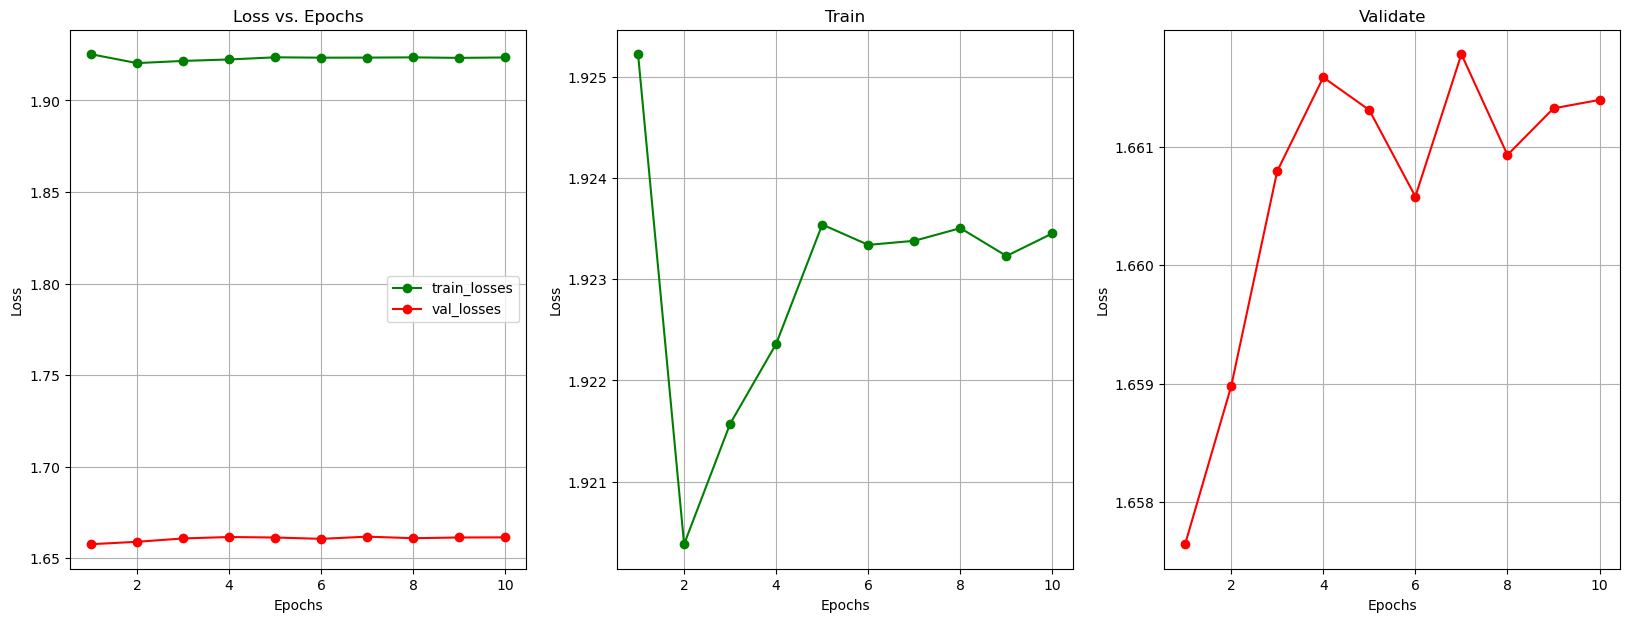

In [32]:
plot_loss(train_losses, val_losses)

### TODO#6 **(5 points)**

When does the model start to overfit?

**Ans:** The model begins to overfit around epoch 3, as indicated by the increase in validation loss. This happens because the validation data does not fit as closely to the training dataset. In the validation loss plot, you will notice a decrease in loss again at epoch 5. This improvement is due to the learning rate decreasing from 0.01 to 0.002 at epoch 5, leading to a reduction in loss.

### TODO#7 **(5 points)**

Plot the learning rate as a function of the epochs.

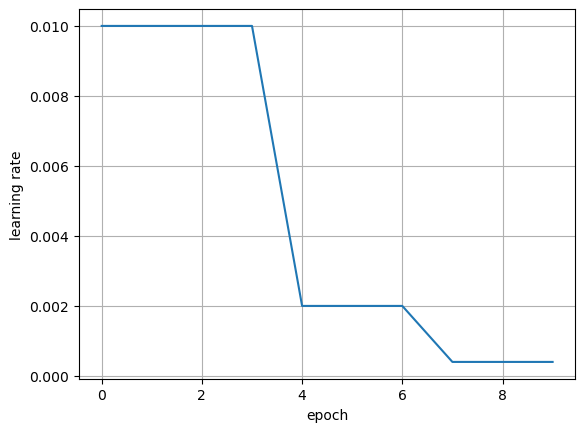

In [33]:
epochs = 10
plt.plot(range(epochs),learning_rates)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.grid()

### TODO#8 **(5 points)**

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** Learning rate is reduce every time the validate losses goes up.

# Load Model

Use the code snippet below to load the model you just trained

In [34]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 0 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.



### TODO#9 **(10 points)**

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [35]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        # optimizer use lr = 0.0001
        self.optimizer = optimizer
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=self.custom_lr_schedule)
    
    def custom_lr_schedule(self, epoch):
        if epoch <= 3:
            # Increase linearly from 0.0001 to 0.001 over epochs 0 to 3
            return 1 + (epoch / 3) * 9 # Scale factor from 1 to 10
        elif  epoch <= 6:
            # Decrease linearly from 0.001 to 0.0005 over epochs 3 to 6
            return 10 - (epoch - 3) * (5 / 3) # Scale factor from 10 to 5
        elif  epoch <= 7:
            # Increase linearly from 0.0005 to 0.001 over epochs 6 to 7
            return 5 + (epoch - 6) * 5 # Scale factor from 5 to 10
        else:
             # Decrease linearly from 0.001 to 0.0001 over epochs 7 to 9
             return 10 - (epoch - 7) * (9 / 2) # Scale factor from 10 to 1
    
    def step(self, epoch):
        # Changes the learning rate here    
        self.scheduler.step()


            

In [36]:
# Now train with your scheduler
config = {
    'architecture': 'feedforward',
    'lr': 0.0001, # optimizer use lr = 0.0001
    'hidden_size': 200,
    'epochs': 10
}

# Model with scheduler
model_ff_scdl = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff_scdl = model_ff_scdl.to(device)
optimizer = torch.optim.Adam(model_ff_scdl.parameters(), lr=config['lr']) 
my_scheduler = MyScheduler(optimizer)



In [37]:
# Training

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-lr-scheduler',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff_scdl, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = my_scheduler.optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_scdl.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        my_scheduler.optimizer.zero_grad()

        # Predict
        y_pred = model_ff_scdl(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        my_scheduler.optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff_scdl.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff_scdl(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        my_scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_scdl.state_dict(),
                'optimizer': my_scheduler.optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_scdl.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

# wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9185
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6573
Saving new best model..
Training epoch 2...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9185
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6560
Saving new best model..
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9186
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6566
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9183
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6570
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9186
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6556
Saving new best model..
Training epoch 6...
Current LR: 0.0006666666666666666


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9177
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6567
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9179
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6557
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9180
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6570
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9176
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6561
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9169
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6557
Finished Training


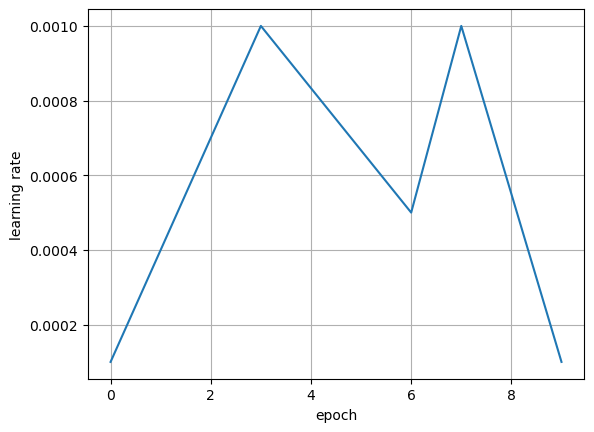

In [38]:
#Plot the learning rate as a function of the epochs.
plt.plot(range(10),learning_rates)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.grid()

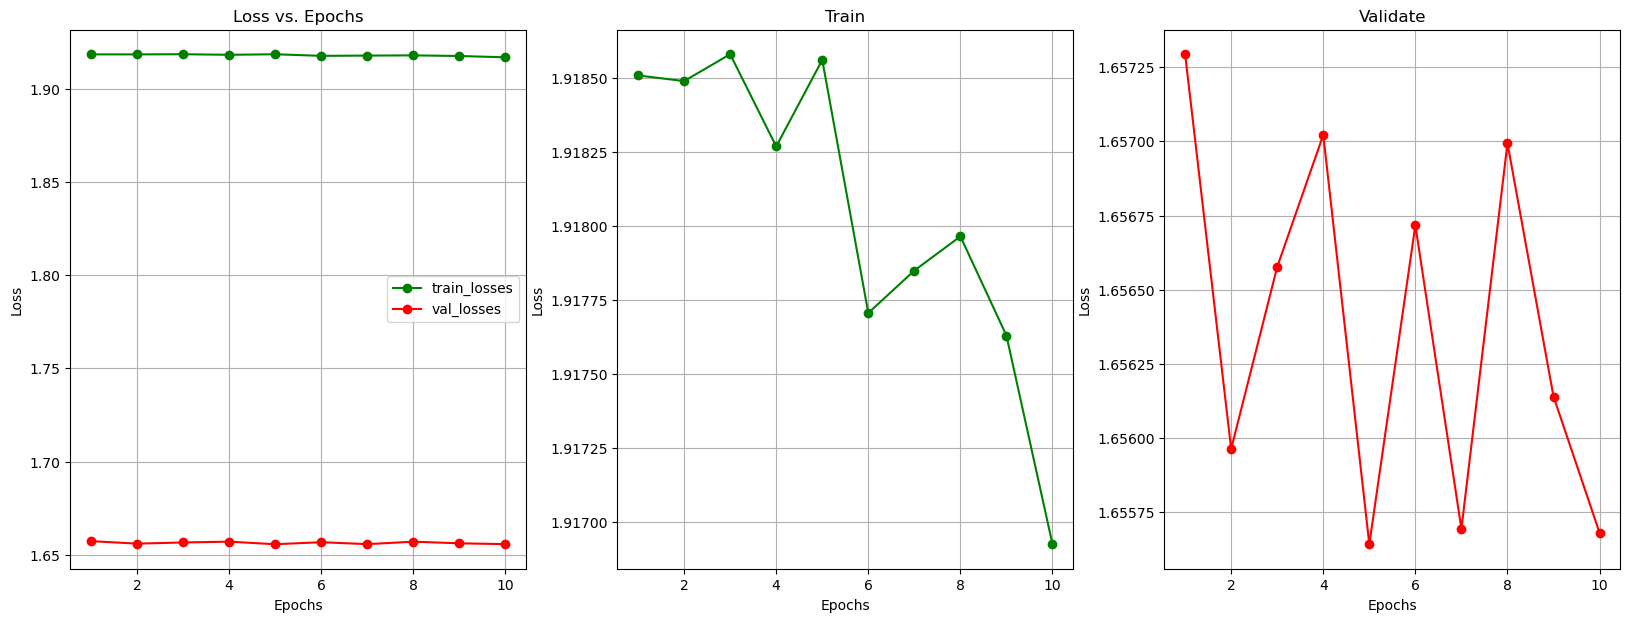

In [39]:
plot_loss(train_losses, val_losses)


# Evaluation

### TODO#10 **(10 points)**

In [40]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    model.eval()
    with torch.no_grad(): # No gradient is required during validation
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs)

            # Calculate MSE loss
            mse_loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(mse_loss)

        avg_val_loss = torch.stack(val_loss).mean()
        # val_losses.append(avg_val_loss)
        # print(f"MSE loss: {avg_val_loss:.4f}")
        
    return avg_val_loss

In [41]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [42]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [43]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9232417345046997


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6613954305648804


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

### TODO#11 **(10 points)**

In [44]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNN_with_dropout(nn.Module):
    def __init__(self, hidden_size=200, drop_out = 0.2):
        super(FeedForwardNN_with_dropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.dropout1 = nn.Dropout(p = drop_out)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p = drop_out)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        do1 = self.dropout1(hd1)
        hd2 = F.relu(self.ff2(do1))
        # do1 = self.dropout2(hd2)
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

In [45]:
# Hyperparameters and other configs
config = {
    'dropout' : 0.2, # set dropout 20 %
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff_dropout = FeedForwardNN_with_dropout(hidden_size=config['hidden_size'], drop_out=config['dropout'])
model_ff_dropout = model_ff_dropout.to(device)
optimizer = torch.optim.Adam(model_ff_dropout.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [46]:
summary(model_ff_dropout, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN_with_dropout               [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Dropout: 1-2                           [1024, 200]               --
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 200]               40,200
├─Linear: 1-5                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

In [47]:
################################################################################                                         
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-with-dropout',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff_dropout, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_dropout.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff_dropout(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff_dropout.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff_dropout(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_dropout.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_dropout.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })
wandb.unwatch(models=model_ff_dropout)
wandb.finish()
print('Finished Training')

start training ff dropout


lr,▁▃▆█▇▅▄█▄▁
train_loss,███▇█▄▅▅▄▁
val_loss,█▂▅▇▁▆▁▇▃▁
lr,0.0001
train_loss,1.91692
val_loss,1.65568


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9266
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6578
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9207
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6579
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9210
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6595
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9206
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6639
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9204
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6588
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9203
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6582
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9204
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6585
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9202
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6591
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9200
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6588
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9194
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6586


lr,████▂▂▂▁▁▁
train_loss,█▂▃▂▂▂▂▂▂▁
val_loss,▁▁▃█▂▁▂▃▂▂
lr,0.0004
train_loss,1.91945
val_loss,1.65857


Finished Training


### TODO#12 **(10 points)**

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

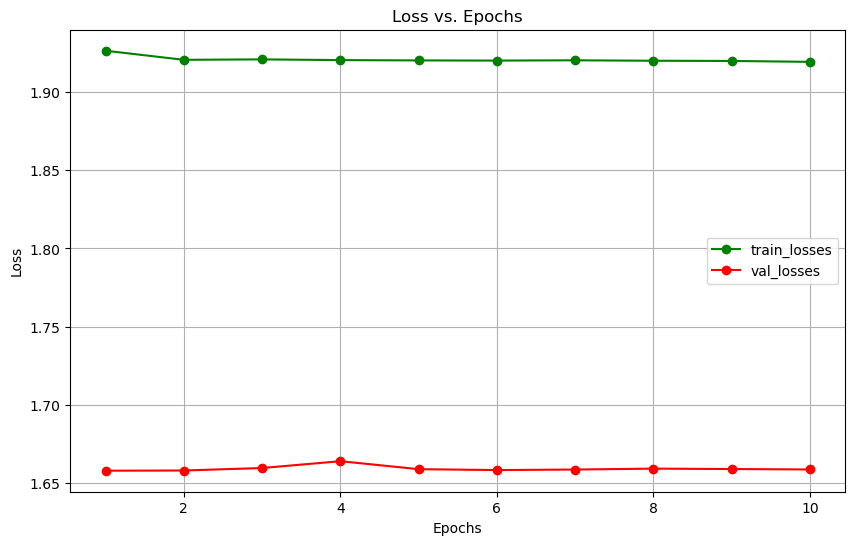

In [48]:
# Plot here
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, config['epochs']+1), train_losses, label='train_losses', marker='o', color='green')
plt.plot(range(1, config['epochs']+1), val_losses, label='val_losses', marker='o', color='red')

plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Evaluate
print('FF-model-with-dropout')
print('train', evaluate(train_loader, model_ff_dropout).item())
print('validate', evaluate(val_loader, model_ff_dropout).item())


FF-model-with-dropout


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.919616937637329


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6585676670074463


# Convolution Neural Networks
Now let's try to incorporate the grid structure to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure. [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.[here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and [here](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/)

If you're stuck on calculating size of layer between conv and nn, you can see hint [here](https://stackoverflow.com/questions/59108988/flatten-tensor-in-pytorch-convolutional-neural-network-size-mismatch-error).

### TODO#13 **(5 points)**

In [73]:
################################################################################
# TODO#13:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    x_train_cnn = x_train.reshape((-1, 5, 5, 3))
    x_train_cnn = np.array(torch.tensor(x_train_cnn).permute(0, 3, 1, 2))  # move channel to second dim [N, H, W, C] -> [N, C, H, W]

    y_train_cnn = y_train.reshape((-1, 1))
    # y_train_cnn = torch.tensor(y_train_cnn)

    x_val_cnn = x_val.reshape((-1, 5, 5, 3))
    x_val_cnn = np.array(torch.tensor(x_val_cnn).permute(0, 3, 1, 2))

    y_val_cnn = y_val.reshape((-1, 1))
    # y_val_cnn = torch.tensor(y_val_cnn)

    x_test_cnn = x_test.reshape((-1, 5, 5, 3))
    x_test_cnn = np.array(torch.tensor(x_test_cnn).permute(0, 3, 1, 2))

    y_test_cnn = y_test.reshape((-1, 1))
    # y_test_cnn = torch.tensor(y_test_cnn)

    return x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn

x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_for_cnn(x_train, y_train, x_val, y_val)
print(x_train_cnn.shape, y_train_cnn.shape)
print(x_val_cnn.shape, y_val_cnn.shape)
print(x_test_cnn.shape, y_test_cnn.shape)


(1147740, 3, 5, 5) (1147740, 1)
(464195, 3, 5, 5) (464195, 1)
(558575, 3, 5, 5) (558575, 1)


In [74]:
# Calculate mean and std of training data for normalize
tensor = torch.tensor(x_test_cnn)
mean_train = tensor.mean(dim=[0, 2, 3])
std_train = tensor.std(dim=[0, 2, 3])
print('mean_train ', mean_train)
print('std_train ', std_train)

mean_train  tensor([232.6223, 272.0771, 266.8131])
std_train  tensor([ 9.0576, 23.4958, 23.1252])


In [75]:
class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)
        self.normalizer = normalizer # Normalize and add more augmentation here
        print(self.x.shape)
        print(self.y.shape)
        self.mean = [232.6223, 272.0771, 266.8131]
        self.std = [ 9.0576, 23.4958, 23.1252]
        
        self.transform = transforms.Compose([
                        transforms.Normalize(self.mean, self.std)
                    ])
    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.transform(x) # Normalize and add more augmentation here
        x = x.float()
        y = self.y[index]
        y = y.float()
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [76]:
# normalizer = normalizer_std(x_train_cnn) # We will normalize everything based on x_train

train_dataset_cnn = RainfallDatasetCNN(x_train_cnn, y_train_cnn, normalizer)
val_dataset_cnn = RainfallDatasetCNN(x_val_cnn, y_val_cnn, normalizer)
test_dataset_cnn = RainfallDatasetCNN(x_test_cnn, y_test_cnn, normalizer)

torch.Size([1147740, 3, 5, 5])
torch.Size([1147740, 1])
torch.Size([464195, 3, 5, 5])
torch.Size([464195, 1])
torch.Size([558575, 3, 5, 5])
torch.Size([558575, 1])


In [77]:
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)

### TODO#14 **(10 points)**

In [78]:
################################################################################
# TODO#14:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class CNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 200, 3) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(hidden_size*3*3, hidden_size) # 3 is output size after convolute
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        flat = conv1.view(x.size(0), -1)
        hd1 = F.relu(self.fc1(flat))
        hd2 = F.relu(self.fc2(hd1))
        y = self.out(hd2)
        return y.reshape(-1, 1)

In [79]:
# Hyperparameters and other configs
config = {
    'architecture': 'cnn',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_cnn = CNN(hidden_size=config['hidden_size'])
model_cnn = model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [80]:
summary(model_cnn, input_size=(1024, 3, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (M): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

### TODO#15 **(10 points)**

In [81]:
################################################################################
# TODO#15:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-cnn',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_cnn, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_cnn.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_cnn)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_cnn(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_cnn.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_cnn)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_cnn(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_cnn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_cnn.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.unwatch(models=model_cnn)

wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 2.2011
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6589
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9226
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6592
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9224
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6606
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9234
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6615
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9232
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6607
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9234
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6611
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9234
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6610
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9233
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6611
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9232
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6613
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9233
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6610


lr,████▂▂▂▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▁▂▆█▆▇▇▇▇▇
lr,0.0004
train_loss,1.92327
val_loss,1.66103


Finished Training


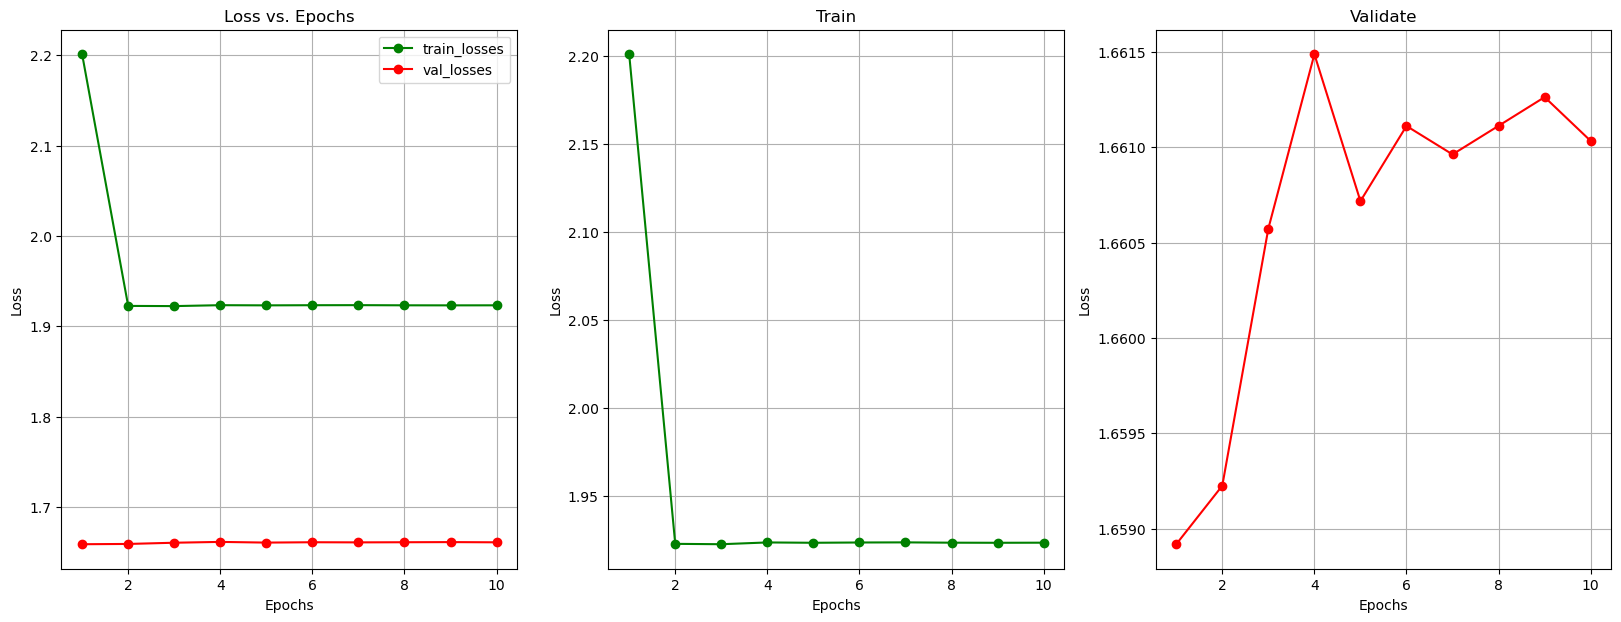

In [82]:
# Plot losses

plot_loss(train_losses, val_losses)

In [83]:
# Evaluate
print('CNN-model')
print('train', evaluate(train_loader_cnn, model_cnn).item())
print('validate', evaluate(val_loader_cnn, model_cnn).item())

CNN-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9231842756271362


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6610324382781982


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


### TODO#16 **(5 points)**

In [84]:
################################################################################
# TODO#16:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def preprocess_for_gru(x_train, y_train, x_val, y_val):
    x_train_gru = x_train.reshape((-1, 5*5*5*3))
    y_train_gru = y_train

    x_val_gru = x_val.reshape((-1, 5*5*5*3))
    y_val_gru = y_val

    x_test_gru = x_test.reshape((-1, 5*5*5*3))
    y_test_gru = y_test

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)

(229548, 375) (229548, 5)
(92839, 375) (92839, 5)
(111715, 375) (111715, 5)


In [85]:
class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer # Normalize and add more augmentation here
        print(self.x.shape)
        print(self.y.shape)
        
    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize and add more augmentation here
        x = x.reshape(5, 5*5*3)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [86]:
normalizer = normalizer_std(x_train_gru) # We will normalize everything based on x_train

train_dataset_gru = RainfallDatasetGRU(x_train_gru, y_train_gru, normalizer)
val_dataset_gru = RainfallDatasetGRU(x_val_gru, y_val_gru, normalizer)
test_dataset_gru = RainfallDatasetGRU(x_test_gru, y_test_gru, normalizer)

(229548, 375)
(229548, 5)
(92839, 375)
(92839, 5)
(111715, 375)
(111715, 5)


In [87]:
train_loader_gru = DataLoader(train_dataset_gru, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_gru = DataLoader(val_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_gru = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)

### TODO#17 **(10 points)**

In [88]:
################################################################################
# TODO#17                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class GRU(nn.Module):
    def __init__(self, hidden_size=200):
        super(GRU, self).__init__()
        self.gru1 = nn.GRU(input_size = 5*5*3, hidden_size = 200, num_layers=1, batch_first=True)
        # self.h_0 = torch.randn(2*1, 1024, 200) # D ∗ num_layers, batch, H_out
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru1, _ = self.gru1(x)
        hd1 = F.relu(self.fc1(gru1))
        y = self.out(hd1)
        # print(y.shape)
        return y.squeeze(-1)

In [89]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_gru = GRU(hidden_size=config['hidden_size'])
model_gru = model_gru.to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [90]:
sample_inputs = next(iter(train_loader_gru))[0].requires_grad_(True)
sample_y = model_gru(sample_inputs.to(device))
print(sample_inputs.size(),sample_y.size())

torch.Size([1024, 5, 75]) torch.Size([1024, 5])


In [91]:
sample_y[0:1]

tensor([[0.0849, 0.0730, 0.0568, 0.0511, 0.0609]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [92]:
summary(model_gru, input_size=(1024, 5, 75))


Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1024, 5]                 --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
Total mult-adds (M): 892.31
Input size (MB): 1.54
Forward/backward pass size (MB): 16.42
Params size (MB): 0.83
Estimated Total Size (MB): 18.79

### TODO#18 **(10 points)**

In [93]:
################################################################################
# TODO#18                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-gru',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_gru, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_gru.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_gru)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_gru(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_gru.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_gru)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_gru(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_gru.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.unwatch(models=model_gru)
wandb.finish()
print('Finished Training')

start training gru


Training epoch 1...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9420
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6715
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9107
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6710
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9074
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6695
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9192
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6702
Training epoch 5...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9154
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6706
Training epoch 6...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9142
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6696
Training epoch 7...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9101
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6684
Saving new best model..
Training epoch 8...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9039
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6679
Saving new best model..
Training epoch 9...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9227
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6698
Training epoch 10...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9107
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6687


lr,██████▁▁▁▁
train_loss,█▂▂▄▃▃▂▁▄▂
val_loss,█▇▄▅▆▄▂▁▅▃
lr,0.002
train_loss,1.91068
val_loss,1.66869


Finished Training


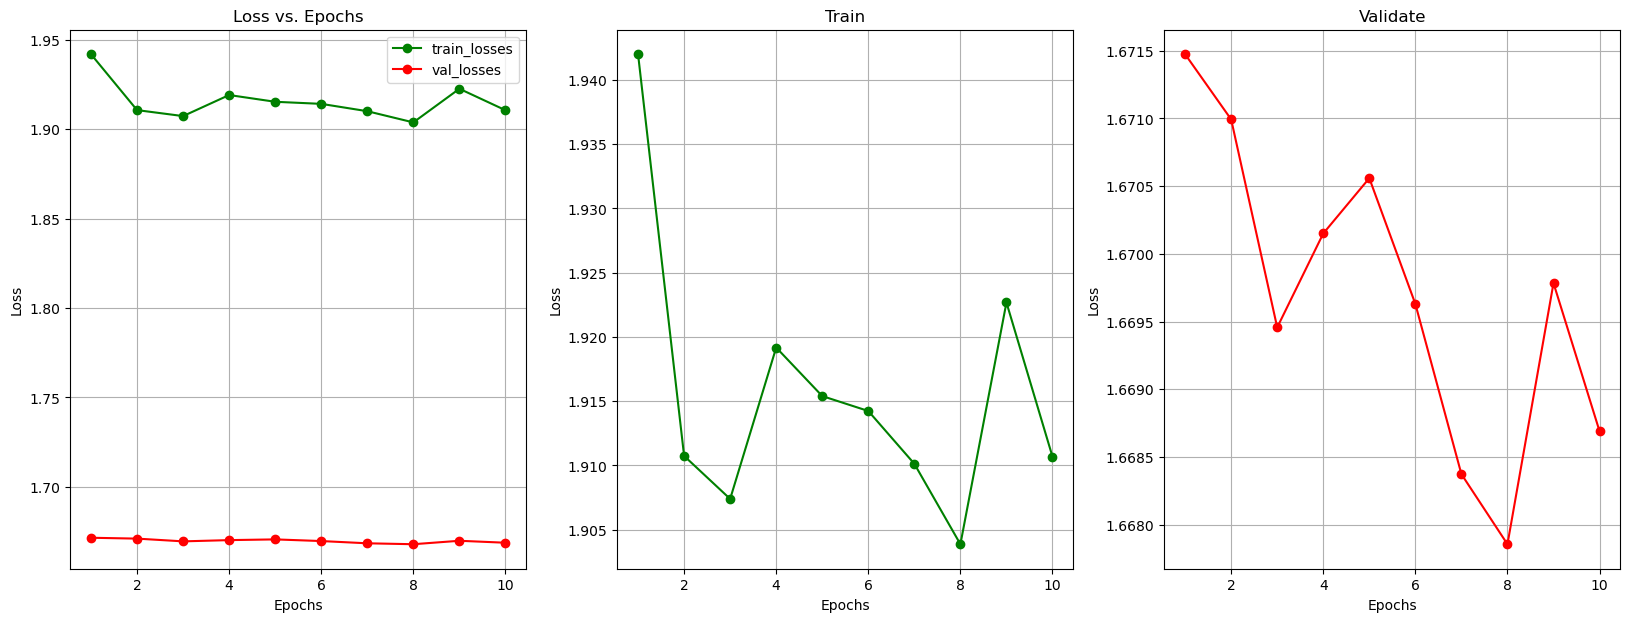

In [94]:
# Plot
plot_loss(train_losses, val_losses)

In [95]:
# Evaluate
print('GRU-model')
print('train', evaluate(train_loader_gru, model_gru).item())
print('validate', evaluate(val_loader_gru, model_gru).item())

GRU-model


  0%|          | 0/225 [00:00<?, ?it/s]

train 1.9069870710372925


  0%|          | 0/91 [00:00<?, ?it/s]

validate 1.668690800666809


# Final Section **(Extra!!!) (5%)**
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
**Your model should be better than your CNN or GRU model in the previous sections!!!.**

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [96]:
# Prep data as you see fit


### TODO#19 **(20 points)**

In [97]:
################################################################################                                                                     #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [98]:
################################################################################                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


start training the best model


In [99]:
# Evaluate best model on validation and test set


In [100]:
# Also evaluate your fully-connected model and CNN/GRU model on the test set.


To get full credit for this part, your best model should be better than the previous models on the **test set**.



### TODO#20 **(5 points)**

Explain what helped and what did not help here

**Ans:**

## Augmentation using data loader



###TODO#21 **(10 points)**

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [101]:
# Write Dataset/DataLoader with noise here


In [102]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


start training the best model with noise


In [103]:
# Evaluate the best model trained with noise on validation and test set
